In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import numpy as np
import os
import math
from scipy.optimize import minimize

import package_DBR
from package_DBR import myRound, FOPDT, SOPDT, Process, Bode, FOPDT_cost, SOPDT_cost

# Load cleaned data

In [4]:
nameFile = 'Cleaned_data_Open_loop_experiment_on_MV_2024-03-11-09h21.txt'

titleName = nameFile.split('.')[0]    
data = pd.read_csv('Data/' + nameFile)

if 'MV' in nameFile:
    ExpVariable = 'MV'
    tm = data['tm'].values
    MVm = data['MVm'].values
    PVm = data['PVm'].values    
else:    
    ExpVariable = 'DV'
    tm = data['tm'].values
    DVm = data['DVm'].values 
    PVm = data['PVm'].values
     
print(ExpVariable)    

MV


# Plot clean data

(0.0, 665.0)

<Figure size 2200x2200 with 0 Axes>

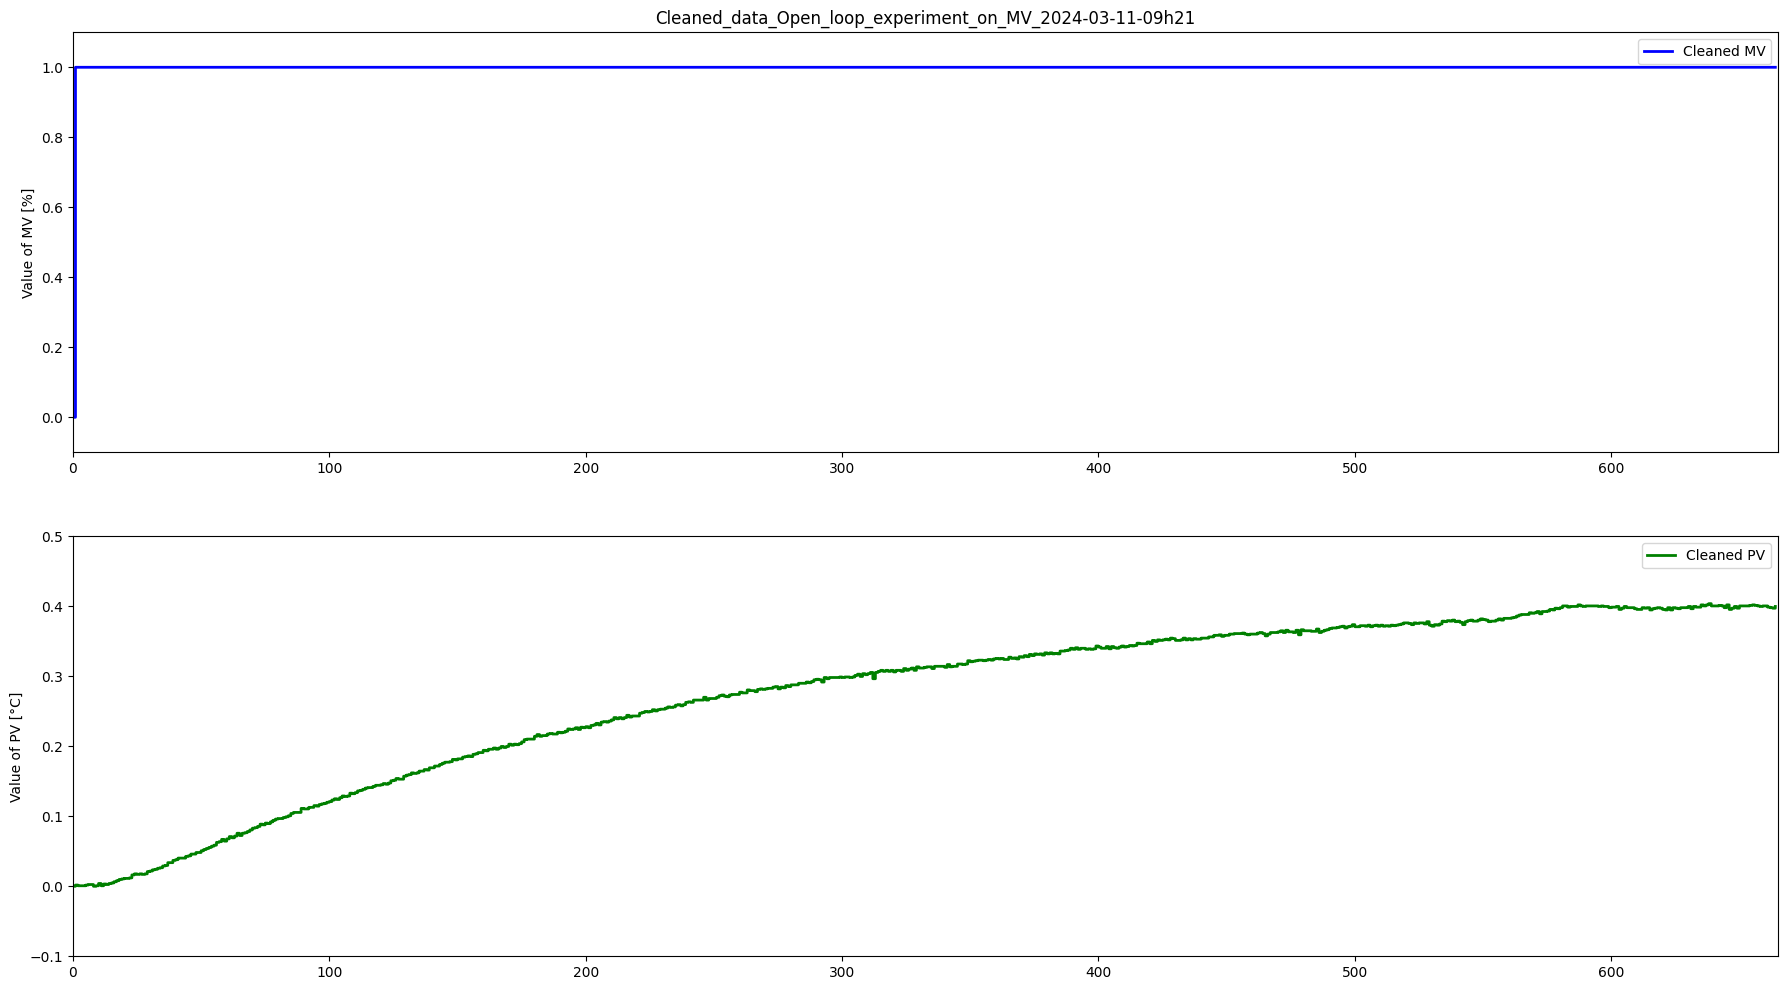

In [5]:
plt.figure(figsize = (22,22))

fig, (ax1, ax2) = plt.subplots(2,1)
fig.set_figheight(12)
fig.set_figwidth(22)

if ExpVariable == 'MV':
    l1, = ax1.step([0,1],[0,100],'b-',linewidth=2,label='Cleaned MV',where='post')
    ax1.set_ylabel('Value of MV [%]')
    ax1.set_title(titleName)
    ax1.legend(loc='best')
    l1.set_data(tm,MVm)
    ax1.set_ylim(myRound(np.min(MVm),1)-0.1, myRound(np.max(MVm),1)+0.1)    
else:
    l1, = ax1.step([0,1],[0,100],'b-',linewidth=2,label='Cleaned DV',where='post')
    ax1.set_ylabel('Value of DV [%]')
    ax1.set_title(titleName)
    ax1.legend(loc='best')
    l1.set_data(tm,DVm)
    ax1.set_ylim(myRound(np.min(DVm),1)-0.1, myRound(np.max(DVm),1)+0.1)     

l2, = ax2.step([0,1],[0,100],'g-',linewidth=2,label='Cleaned PV',where='post')
ax2.set_ylabel('Value of PV [°C]')
ax2.legend(loc='best')
l2.set_data(tm,PVm)
ax2.set_ylim(myRound(np.min(PVm),0.1)-0.1, myRound(np.max(PVm),0.1)+0.1)

ax1.set_xlim(0, tm[-1]+1)
ax2.set_xlim(0, tm[-1]+1)

# Load parameter

In [6]:
Tu = 13
t1 = 88
t2 = 132
Tg = 277
Kp = 0.4
a = 0.11
e = np.exp(1)

Ts = 1

#Broida 1
T_FOPDT1 = Tg
Theta_FOPDT1 = Tu

print ("T_FOPDT1: ",T_FOPDT1)
print ("Theta_FOPDT1: ",Theta_FOPDT1)

#Broida 2
T_FOPDT2 = 5.5*(t2-t1)
Theta_FOPDT2 = (2.8*t1)-(1.8*t2)

print ("T_FOPDT2: ",T_FOPDT2)
print ("Theta_FOPDT2: ",Theta_FOPDT2)

#SOPDT
T1_SOPDT = Tg*((3*a*e-1)/(1+a*e))
T2_SOPDT = Tg*((1-a*e)/(1+a*e))
Theta_SOPDT = Tu - (T1_SOPDT*T2_SOPDT)/(T1_SOPDT+3*T2_SOPDT)

print ("T1_SOPDT: ",T1_SOPDT)
print ("T2_SOPDT: ",T2_SOPDT)
print ("Theta_SOPDT: ",Theta_SOPDT)
#-> T1 négatif -> instable (courbe pas suffisamment en S) 

#Strejc
n = 1 #Tu/Tg= 0,05
T_strejc = Tg/1
Tuth = 0*Tg
Theta_strejc = Tu - Tuth

print ("n: ",n)
print ("T_strejc: ",T_strejc)
print ("Theta_strejc: ",Theta_strejc)

#OPT SOPDT
Kp_SOPDTOPT= 0.4306576253666714
T1_SOPDTOPT= 238.7362471589338
T2_SOPDTOPT= 15.201603494821217
Theta_SOPDTOPT= 3.1282416191455016

#OPT FOPDT
Kp_FOPDTOPT= 0.43117146633002806
T_FOPDTOPT= 240.06677879648248
Theta_FOPDTOPT= 18.702701935008474

T_FOPDT1:  277
Theta_FOPDT1:  13
T_FOPDT2:  242.0
Theta_FOPDT2:  8.799999999999983
T1_SOPDT:  -21.95659469837965
T2_SOPDT:  149.47829734918983
Theta_SOPDT:  20.695665668100315
n:  1
T_strejc:  277.0
Theta_strejc:  13


# Compute Model

(0.0, 664.0)

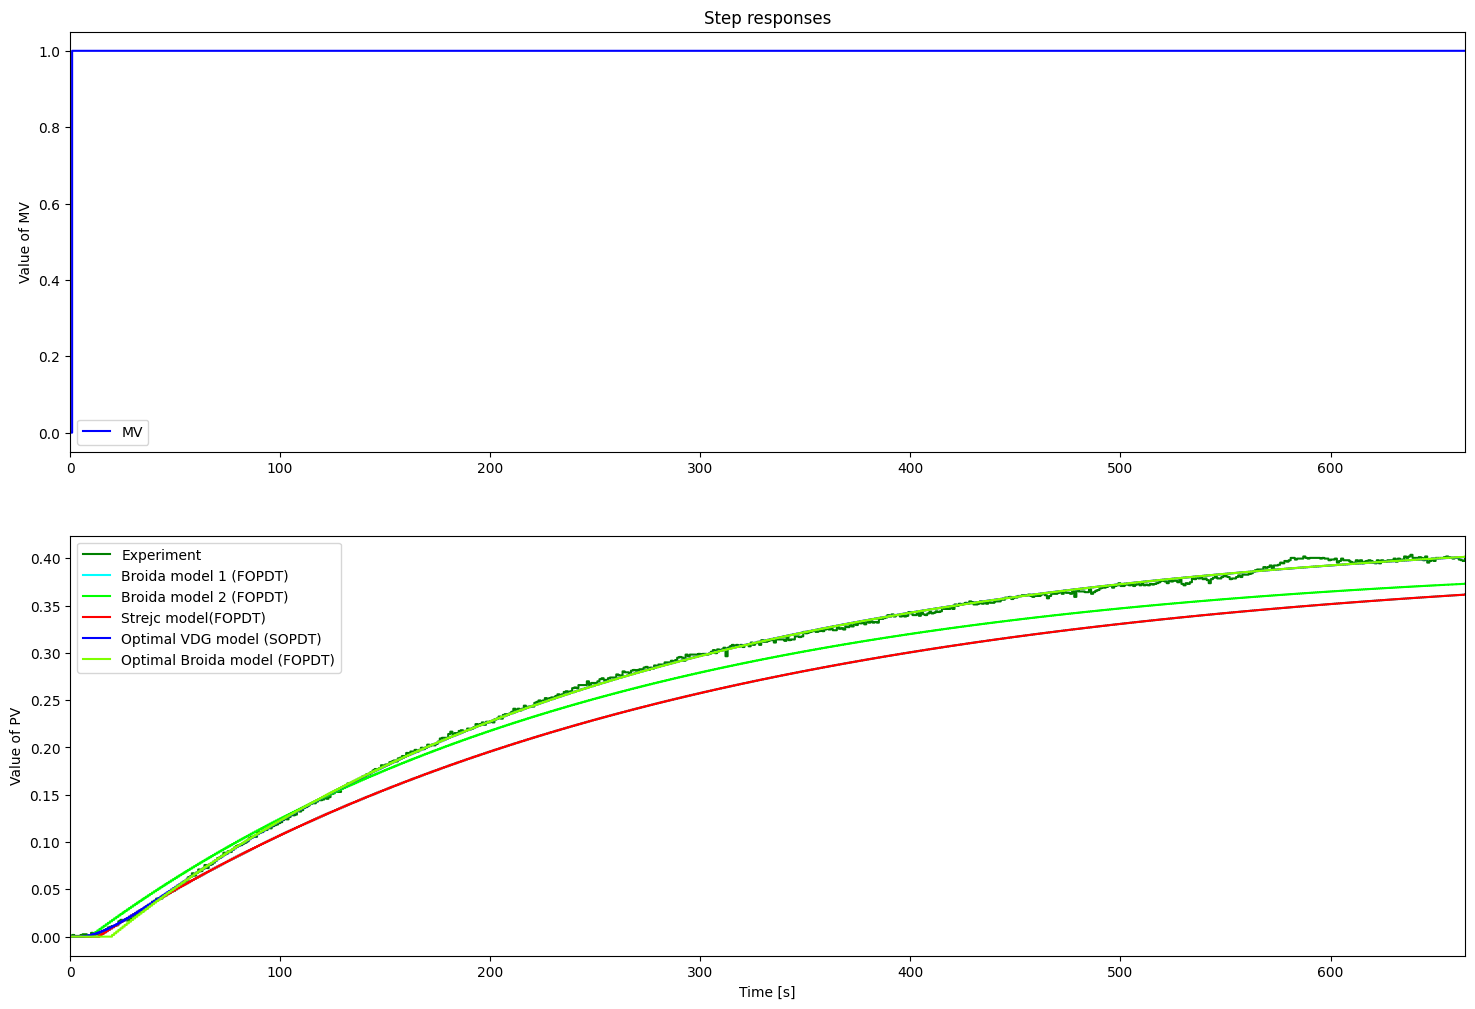

In [7]:
PV_FOPDT1 = FOPDT(MVm,Kp,T_FOPDT1,Theta_FOPDT1,Ts)
PV_FOPDT2 = FOPDT(MVm,Kp,T_FOPDT2,Theta_FOPDT2,Ts)
PV_Strejc = FOPDT(MVm,Kp,T_strejc,Theta_strejc,Ts)
PV_SOPDTOPT =  SOPDT(MVm,Kp_SOPDTOPT,T1_SOPDTOPT,T2_SOPDTOPT,Theta_SOPDTOPT,Ts)
PV_FOPDTOPT = FOPDT(MVm,Kp_FOPDTOPT,T_FOPDTOPT,Theta_FOPDTOPT,Ts)

plt.figure(figsize = (18,12))

plt.subplot(2,1,1)
plt.step(tm,MVm,'b-',label='MV',where='post')
plt.ylabel('Value of MV')
plt.title('Step responses')
plt.legend(loc='best')
plt.xlim([0, np.max(tm)])   

plt.subplot(2,1,2)
plt.step(tm,PVm,'g-',label='Experiment',where='post')
plt.step(tm,PV_FOPDT1,'cyan',label='Broida model 1 (FOPDT)',where='post')
plt.step(tm,PV_FOPDT2,'lime',label='Broida model 2 (FOPDT)',where='post')
plt.step(tm,PV_Strejc,'red',label='Strejc model(FOPDT)',where='post')
plt.step(tm,PV_SOPDTOPT,'blue',label='Optimal VDG model (SOPDT)',where='post')
plt.step(tm,PV_FOPDTOPT,'chartreuse',label='Optimal Broida model (FOPDT)',where='post')

plt.ylabel('Value of PV')
plt.xlabel('Time [s]')
plt.legend(loc='best')  
plt.xlim([0, np.max(tm)])